 # Práctica de aprendizaje automático (parte 2)

Entrega este cuaderno habiendo **ejecutado todas las celdas**. Incluye en la entrega **todos los ficheros necesarios para su ejecución**.

Asegúrate de que la presentación está bien estructurada: Se valorará la **claridad, concisión, y completitud** del informe.

Se trata de una práctica abierta: **sé intrépido y explora**. 

1. Describe las características de los datos:
    * Tipo de datos (e.g. [https://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data)](https://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data)))
    * Número de ejemplos de cada una de las clases.
    * Número y tipo (nominales no ordenados, nominales ordenados, numéricos) de atributos.

Esta información se debería utilizar en el análisis; por ejemplo, si se selecciona un atributo para la predicción, ¿es clara su relevancia por el tipo de información que proporciona de acuerdo con nuestro conocimiento experto sobre el área?
    
2. Detalla la metodología utilizada:
    * Partición de los datos: tamaño de los conjuntos de entrenamiento y test, uso de estratificación en el muestreo.
    * Preprocesamiento: codificación de los atributos, construcción y selección de características, normalización, etc. (¡solo se debe utilizar la información del conjunto de entrenamiento!)
    * Determinación de los hiperparámetros; por ejemplo, mediante búsqueda en rejilla y validación cruzada.
    * Estimación del error de generalización y su incertidumbre.
2. Resume los resultados en gráficas y tablas.
3. Elabora esta información e ilustra tus observaciones con los resultados obtenidos.
4. Proporciona una recomendación final:
    * Tipo de clasificador.
    * Configuración del clasificador (arquitectura, hiperparámetros, etc.) y método de entrenamiento (función de coste, método de optimización, uso de técnicas de regularización,...)
    * Para el predictor final, proporciona los errores de entrenamiento, validación cruzada y test.
5. Resume las conclusiones del análisis.

## 2. Construcción de un clasificador en una base de datos real (4.5 puntos)

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import LocalOutlierFactor
from sklearn.impute import SimpleImputer
from sklearn import datasets
from statistics import mean 

%matplotlib inline

In [27]:
df = pd.read_csv('./data/german_credit_data.csv', sep=';')
# Source: https://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data)
# This dataset classifies people described by a set of attributes as good or bad credit risks. Comes in two formats (one all numeric). Also comes with a cost matrix

print(df.shape)
df.head(5)

(1000, 21)


,default,account_check_status,duration_in_month,credit_history,purpose,credit_amount,savings,present_emp_since,installment_as_income_perc,personal_status_sex,...,present_res_since,property,age,other_installment_plans,housing,credits_this_bank,job,people_under_maintenance,telephone,foreign_worker
0,0,< 0 DM,6,critical account/ other credits existing (not ...,domestic appliances,1169,unknown/ no savings account,.. >= 7 years,4,male : single,...,4,real estate,67,none,own,2,skilled employee / official,1,"yes, registered under the customers name",yes
1,1,0 <= ... < 200 DM,48,existing credits paid back duly till now,domestic appliances,5951,... < 100 DM,1 <= ... < 4 years,2,female : divorced/separated/married,...,2,real estate,22,none,own,1,skilled employee / official,1,none,yes
2,0,no checking account,12,critical account/ other credits existing (not ...,(vacation - does not exist?),2096,... < 100 DM,4 <= ... < 7 years,2,male : single,...,3,real estate,49,none,own,1,unskilled - resident,2,none,yes
3,0,< 0 DM,42,existing credits paid back duly till now,radio/television,7882,... < 100 DM,4 <= ... < 7 years,2,male : single,...,4,if not A121 : building society savings agreeme...,45,none,for free,1,skilled employee / official,2,none,yes
4,1,< 0 DM,24,delay in paying off in the past,car (new),4870,... < 100 DM,1 <= ... < 4 years,3,male : single,...,4,unknown / no property,53,none,for free,2,skilled employee / official,2,none,yes


In [3]:
class_label = 'default'
feature_names = list(df.columns)
feature_names.remove(class_label)
print(feature_names)
X = df[feature_names].values
y = df[class_label].values

['account_check_status ', 'duration_in_month ', 'credit_history ', 'purpose ', 'credit_amount ', 'savings ', 'present_emp_since ', 'installment_as_income_perc ', 'personal_status_sex ', 'other_debtors ', 'present_res_since ', 'property ', 'age ', 'other_installment_plans ', 'housing ', 'credits_this_bank ', 'job ', 'people_under_maintenance ', 'telephone ', 'foreign_worker']


**Estadísticos básicos de cada atributo:**

In [4]:
df.describe()

,default,duration_in_month,credit_amount,installment_as_income_perc,present_res_since,age,credits_this_bank,people_under_maintenance
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.300000,20.903000,3271.258000,2.973000,2.845000,35.546000,1.407000,1.155000
std,0.458487,12.058814,2822.736876,1.118715,1.103718,11.375469,0.577654,0.362086
min,0.000000,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000
25%,0.000000,12.000000,1365.500000,2.000000,2.000000,27.000000,1.000000,1.000000
50%,0.000000,18.000000,2319.500000,3.000000,3.000000,33.000000,1.000000,1.000000
75%,1.000000,24.000000,3972.250000,4.000000,4.000000,42.000000,2.000000,1.000000
max,1.000000,72.000000,18424.000000,4.000000,4.000000,75.000000,4.000000,2.000000


**Datos codificados de forma numérica**

In [5]:
df = pd.read_csv('./data/german_credit_data_numeric.csv', sep=';')
class_label = 'Class'
feature_names = list(df.columns)
feature_names.remove(class_label)
print(feature_names)
X = df[feature_names].values
y = df[class_label].values

['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20', 'X21', 'X22', 'X23']


**Histogramas suavizados de cada atributo en cada clase. El color indica la clase ("default"/"no default"):**

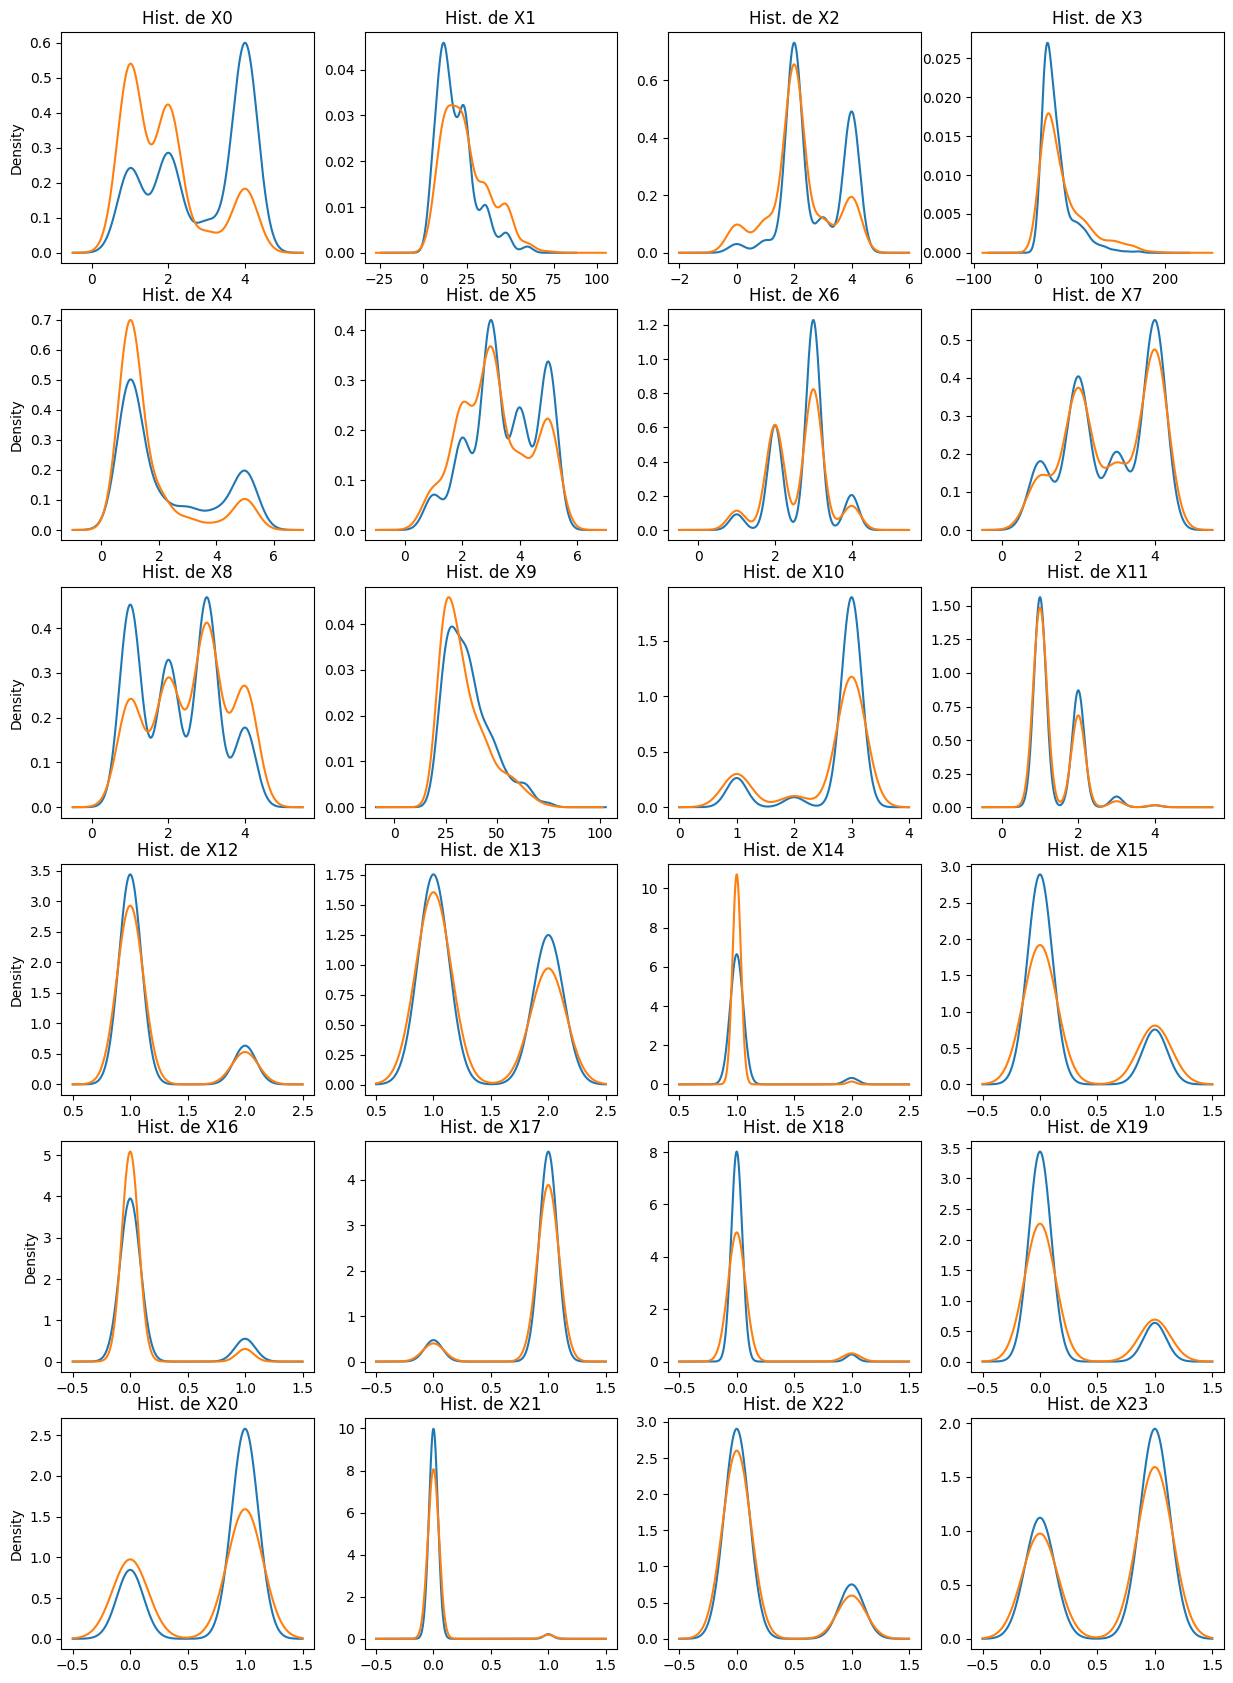

In [6]:
plt.figure(figsize=(15, 21))
n_cols_plot = 4
n_rows_plot = int(len(feature_names) / n_cols_plot)
for i,n in enumerate(feature_names):
    plt.subplot(n_rows_plot, n_cols_plot, i+1)
    aux = 'Density' if i%n_cols_plot == 0 else ''
    df.groupby('Class')[n].plot(kind='kde', title='Hist. de '+n)
    plt.ylabel(aux)

## Entrenamiento de un modelo y chequeo de su calidad usando 5-fold cross validation

La siguiente celda entrena un modelo y lo evalúa en varias particiones training-test diferentes de los datos. El resultado es un score medio junto a su desviación estándar. El tipo de modelo (Naïve Bayes / árbol de decisión / knn/ regresión logística / red neuronal) y parámetros empleados deberán ser seleccionados para que dicho resultado sea el mejor posible.

In [7]:

# otros clasificadores (del notebook p4_01)

clf = KNeighborsClassifier(n_neighbors=1) # DecisionTreeClassifier(max_depth=3)
scores = cross_val_score(clf, X, y, cv=10) # 10-fold cross-validation
print('Precisión en cada una de las particiones: ', scores)
print('Estimación de la precisión por validación cruzada: {:.2f} +/- {:.2f}'.format(scores.mean(), scores.std()))

Precisión en cada una de las particiones:  [0.67 0.64 0.72 0.66 0.64 0.71 0.6  0.71 0.62 0.66]
Estimación de la precisión por validación cruzada: 0.66 +/- 0.04


## Responde aquí a las siguientes preguntas:

* Haz una gráfica que muestre la dependencia de la precisión de un clasificador de vecinos próximos con el número de vecinos. Si es más conveniente, utiliza gráficas en escala logarítmica para alguno de los ejes (`semilogx`, `semilogy`, `loglog`).
  

 K  Puntuacion media
 5             0.690
10             0.703
15             0.712
20             0.702
25             0.706
30             0.710
35             0.712
40             0.707
45             0.710
50             0.709



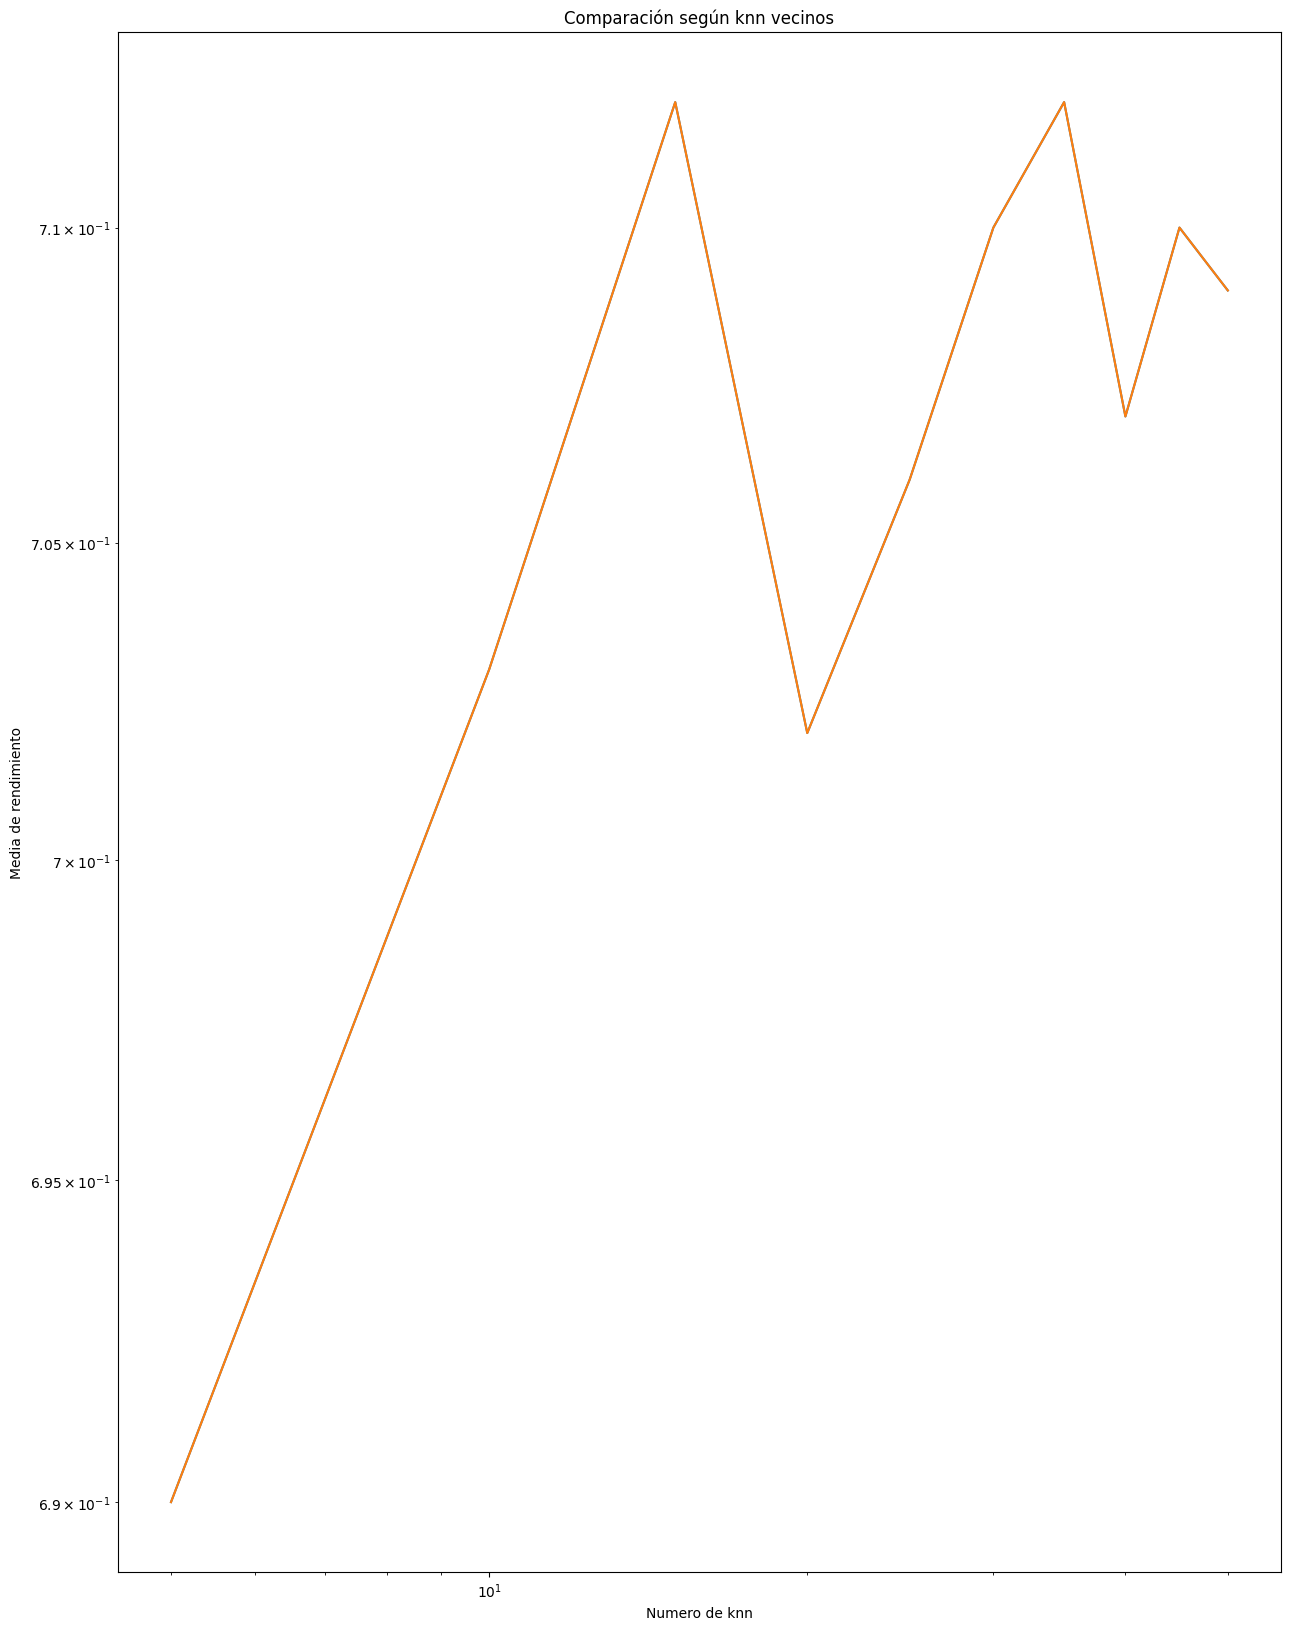


Con k = 15 , se tiene una puntuación de 0.712


In [8]:

number_knn = 10

x_val = [i*5  for i in range(1, number_knn+1)]

headers= ["K", "Puntuacion media"]
data_table = []

score_means = list()
for i in x_val:
    clf = KNeighborsClassifier(n_neighbors=i) # DecisionTreeClassifier(max_depth=3)
    scores = cross_val_score(clf, X, y, cv=10) # 10-fold cross-validation
    m = scores.mean()
    score_means.append(m)
    data_table.append([i, m])

print(pd.DataFrame({headers[0]:x_val, headers[1]:score_means}).to_string(index=False))
print()  

plt.figure(figsize=(15, 20))

plt.plot(x_val, score_means)

plt.loglog(x_val, score_means)
plt.xlabel("Numero de knn")
plt.ylabel("Media de rendimiento")
plt.title("Comparación según knn vecinos")
plt.show()


scores_cpy = score_means.copy()

scores_cpy.sort(reverse=True)

print()
print("Con k =", str(x_val[score_means.index(scores_cpy[0])]) + " , se tiene una puntuación de " + str(scores_cpy[0]))




    

* Utilizando los conceptos de sub- y sobreajuste:
    * Comenta los resultados cuando el número de vecinos es pequeño.
    * Comenta los resultados cuando el número de vecinos es grande.
    * Explica el significado del valor de la precisión cuando el número de vecinos toma el valor mayor posible.
      

Cuando es pequeño (en este caso 5) la puntuación media es bastante peor que con mas vecinos, está subajustado pues no consigue encontrar realmente una diferencia clara entre las distintas áreas de los datos. Al aumentar en 5 los vecinos, la media de rendimiento aumenta notablemente, esto se debe a que el numero de vecinos actua como un "smoothing parameter" y al aumentarlo, en teoría, da mejores resultados, no obstante, hay valores de k que son más grandes y son subóptimos. Esto se debe a que con demasiados vecinos hay un sobreajuste y el algoritmo empieza a ajustarse a datos más especificos, perdiendo capacidad de predictibilidad.

* ¿Cuál es la mejor precisión que se alcanza con k-nn y para qué k (valor de `n_neighbours`)?
  

Para hallar el valor de k más óptimo, se podría utilizar sklearn.model_selection.GridSearchCV, que trata de estimar el mejor valor para un parametro.

In [9]:

max_class = np.max(np.bincount(y))

grid_param = {'n_neighbors': range(1, max_class)} # Parametro a buscar

k_tests = RepeatedStratifiedKFold(n_splits=10, n_repeats=3) # Repite tests aleatoriamente
clf = GridSearchCV(KNeighborsClassifier(), grid_param, cv=k_tests, scoring='accuracy')

clf.fit(X, y)

print("Mejor K:", str(clf.best_params_))
print("Con puntuación:", str(clf.best_score_))



Mejor K: {'n_neighbors': 46}
Con puntuación: 0.7113333333333335


Como se puede ver, la estimación de k es 46, hay que tener en cuenta que es una estimación y que se realizan varios tests de forma aleatoria. Aún así, observando la gráfica, dicho resultado tiene sentido.

* ¿Cuál es la mejor precisión que se alcanza con un árbol de decisión y con qué profundidad máxima (valor de `max_depth`)? Para ello, haz una gráfica que muestre la dependencia de la precisión con la profundidad máxima del árbol. Comenta los resultados.
  

 Profundidad Máxima  Puntuacion media
                  5             0.730
                 10             0.701
                 15             0.686
                 20             0.687
                 25             0.683
                 30             0.685
                 35             0.678
                 40             0.688
                 45             0.682
                 50             0.678



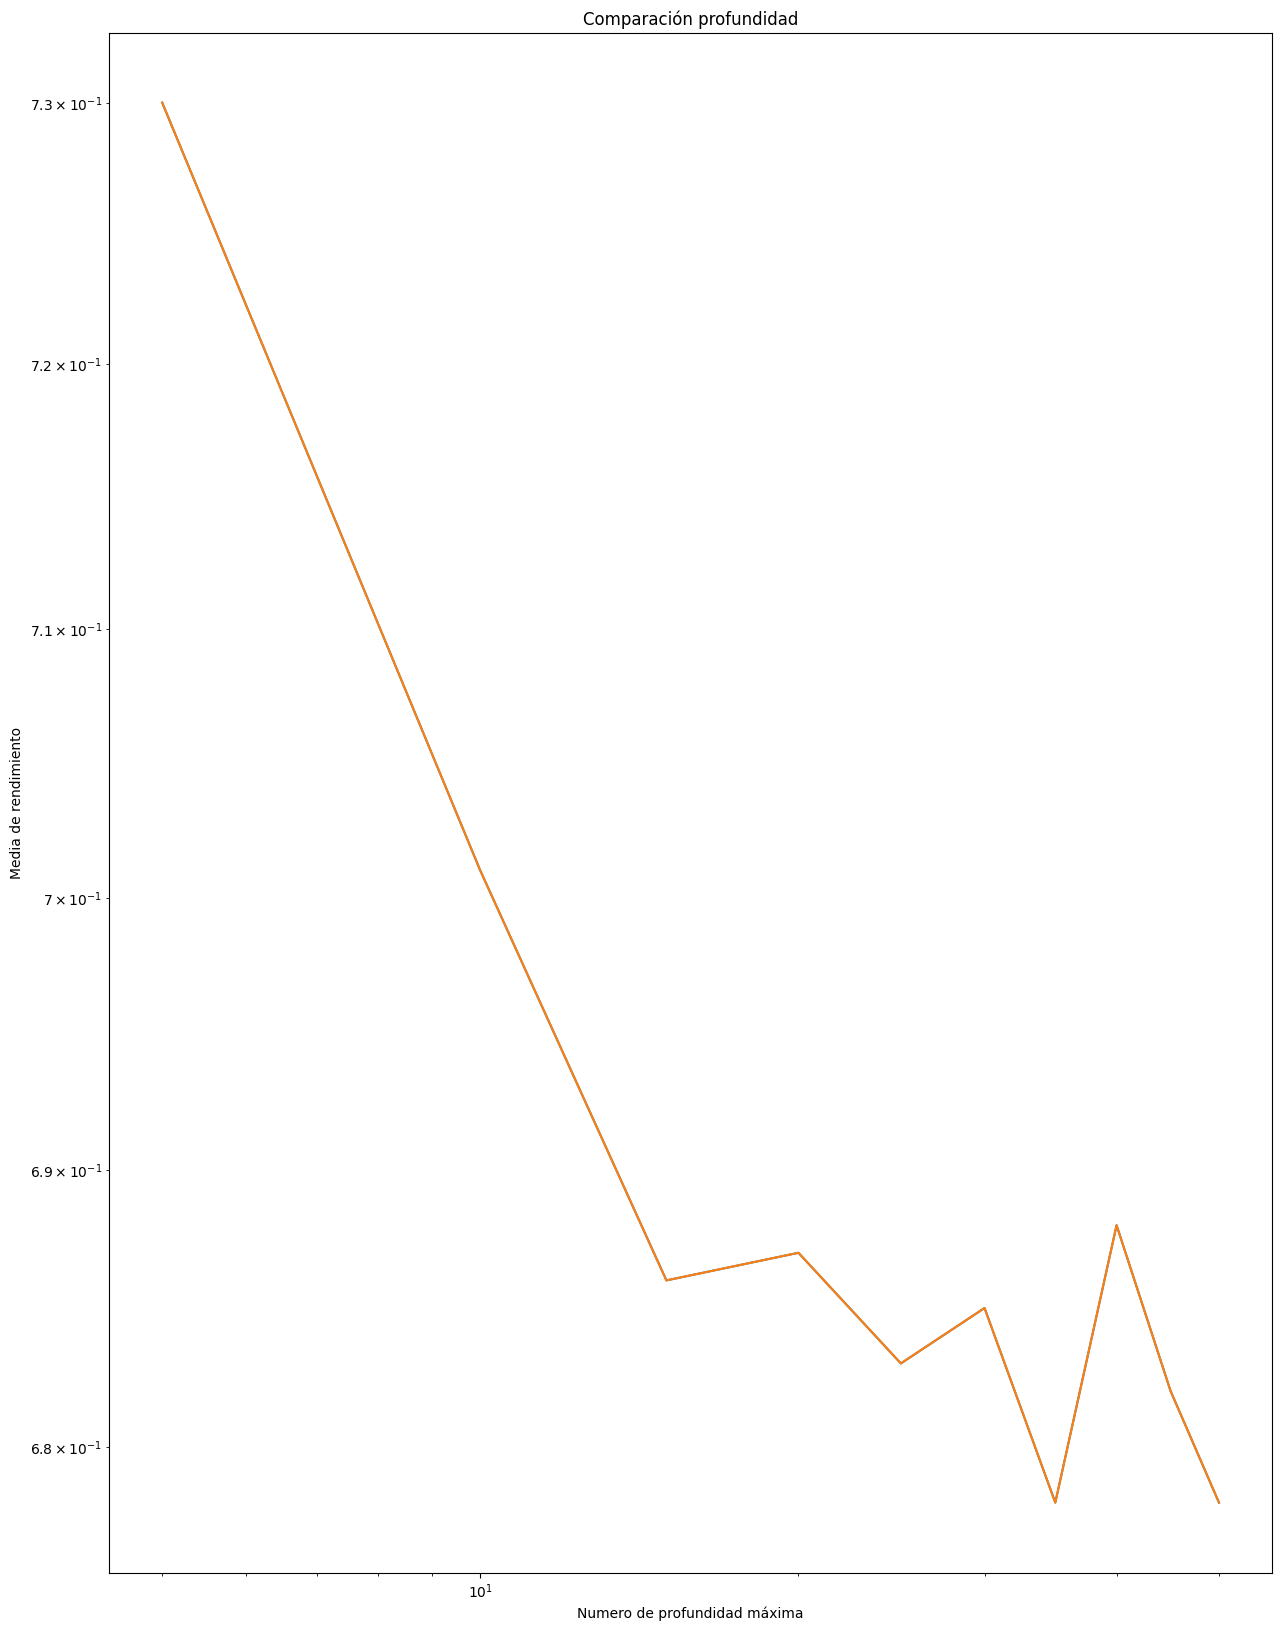


Con max_depth = 5 , se tiene una puntuación de 0.73
Mejor profundidad máxima: {'max_depth': 3}
Con puntuación: 0.7383333333333333


In [14]:
number_depth = 10

x_val = [i*5  for i in range(1, number_depth+1)]


score_means = list()

headers= ["Profundidad Máxima", "Puntuacion media"]
data_table = []

score_means = list()
for i in x_val:
    clf = DecisionTreeClassifier(max_depth=i) # DecisionTreeClassifier(max_depth=3)
    scores = cross_val_score(clf, X, y, cv=10) # 10-fold cross-validation
    m = scores.mean()
    score_means.append(m)
    data_table.append([i, m])

print(pd.DataFrame({headers[0]:x_val, headers[1]:score_means}).to_string(index=False))
print()  
plt.figure(figsize=(15, 20))

plt.plot(x_val, score_means)

plt.loglog(x_val, score_means)
plt.xlabel("Numero de profundidad máxima")
plt.ylabel("Media de rendimiento")
plt.title("Comparación profundidad")
plt.show()



scores_cpy = score_means.copy()

scores_cpy.sort(reverse=True)


print()
print("Con max_depth =", str(x_val[score_means.index(scores_cpy[0])]) + " , se tiene una puntuación de " + str(scores_cpy[0]))

max_class = np.max(np.bincount(y))

grid_param = {'max_depth': range(1, max_class)} # Parametro a buscar

k_tests = RepeatedStratifiedKFold(n_splits=10, n_repeats=3) # Repite tests aleatoriamente
clf = GridSearchCV(DecisionTreeClassifier(), grid_param, cv=k_tests, scoring='accuracy')

clf.fit(X, y)

print("Mejor profundidad máxima:", str(clf.best_params_))
print("Con puntuación:", str(clf.best_score_))


Tal y como muestra la gráfica, una profundidad superior a 5 paraece poco eficiente y tras el uso de GridSearchCV, la estimación de la profundidad es 3, valor muy cercano al 5 y que sigue teniendo una puntuación muy superior al resto de los valores.

* ¿Cuál es la mejor precisión que se alcanza con una red neuronal con una sola capa oculta y con qué configuración (valor de `hidden_layer_sizes`)? Para ello, haz una gráfica que muestre la dependencia de la precisión con el número de nodos en la capa oculta. Comenta los resultados.

 Nº neuronas  Puntuacion media
           5             0.716
          10             0.760
          15             0.740
          20             0.696
          25             0.680
          30             0.692
          35             0.704
          40             0.720
          45             0.704
          50             0.708



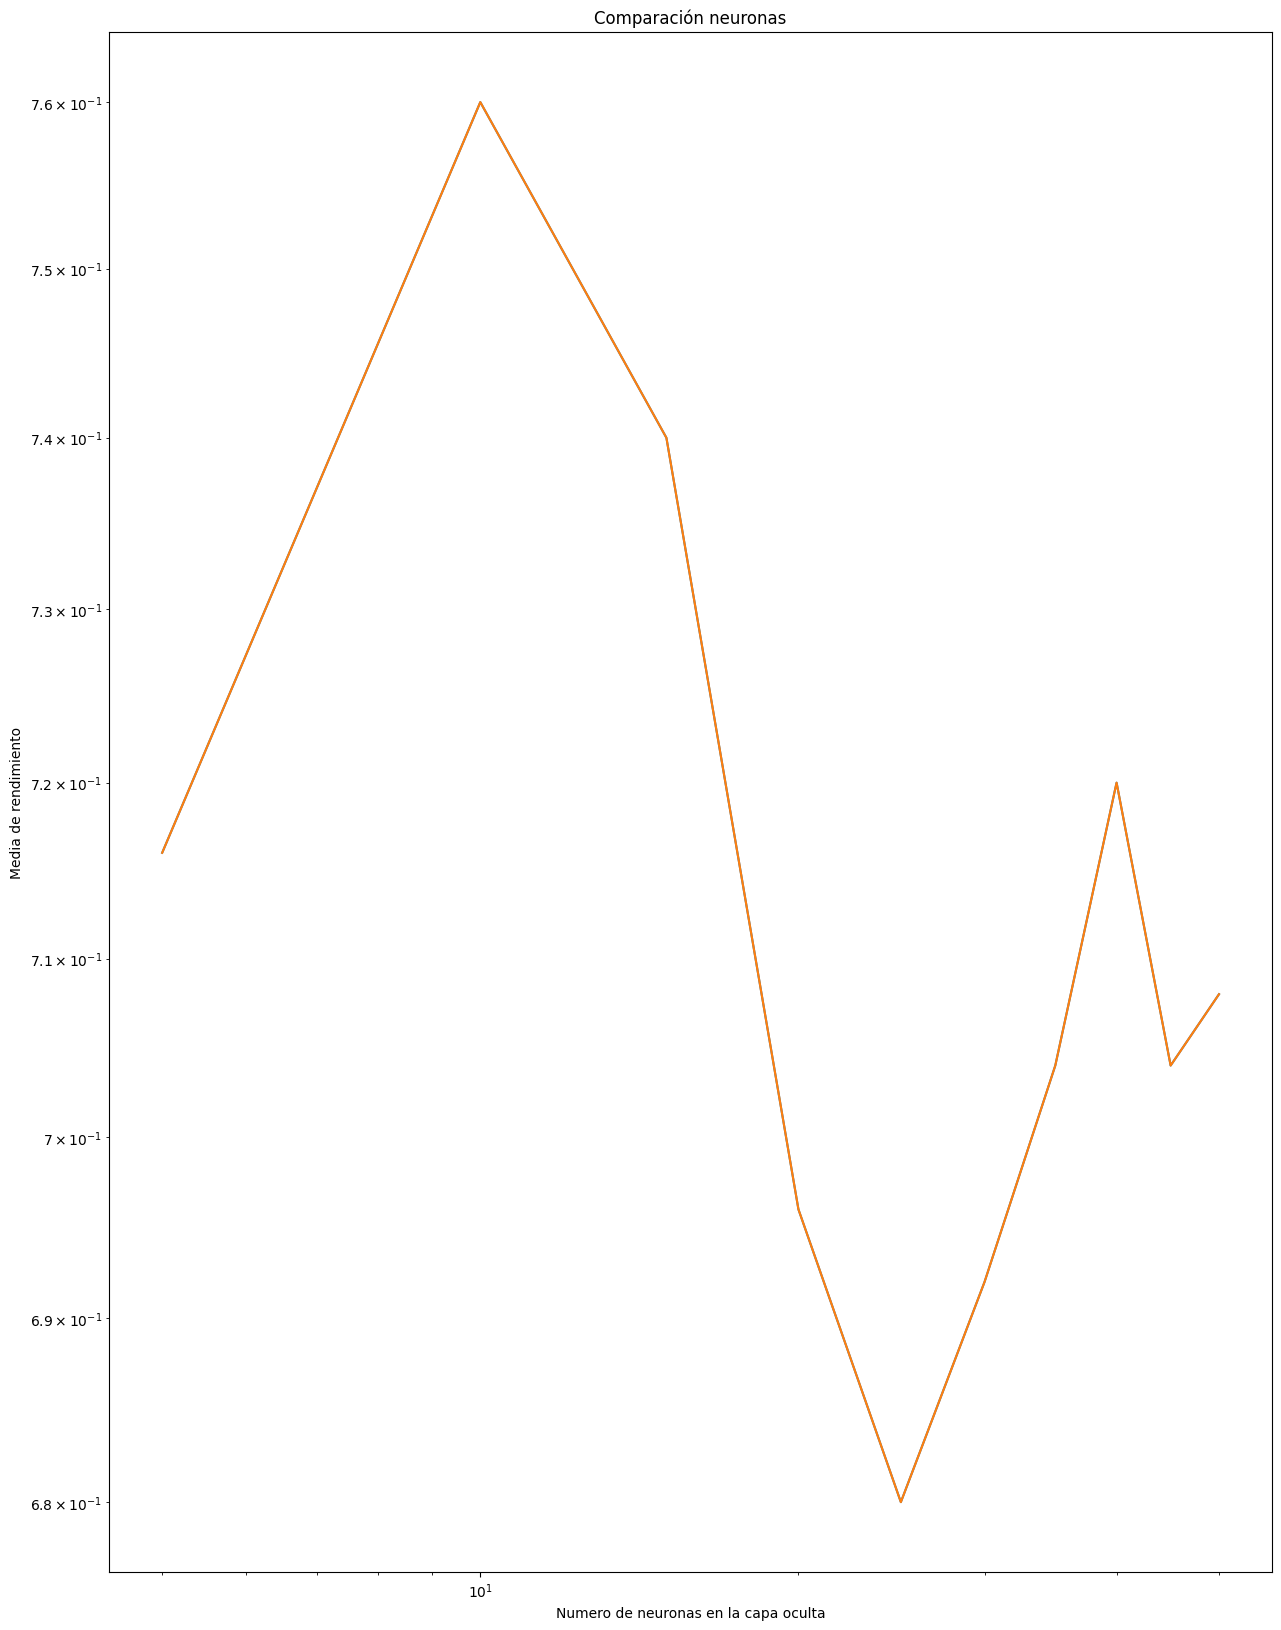


Con 10 neuronas, se tiene una puntuación de 0.76


In [26]:


number_neurons = 10

x_val = [i*5  for i in range(1, number_neurons+1)]

headers= ["Nº neuronas", "Puntuacion media"]

data_table = []

score_means = list()

X = StandardScaler().fit_transform(X)
for i in x_val:
    clf = MLPClassifier(hidden_layer_sizes=(i,), max_iter=3000,alpha=0.0) # 3000 iteraciones para evitar el ConvergenceWarning
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0) # division del entrenamiento
    clf.fit(X_train, y_train) # entrenamiento
    
    scores = cross_val_score(clf, X_test, y_test, cv=10) # 10-fold cross-validation
    m = scores.mean()
    score_means.append(m)
    data_table.append([i, m])

print(pd.DataFrame({headers[0]:x_val, headers[1]:score_means}).to_string(index=False))
print()  
plt.figure(figsize=(15, 20))

plt.plot(x_val, score_means)

plt.loglog(x_val, score_means)
plt.xlabel("Numero de neuronas en la capa oculta")
plt.ylabel("Media de rendimiento")
plt.title("Comparación neuronas")
plt.show()


scores_cpy = score_means.copy()

scores_cpy.sort(reverse=True)


print()
print("Con", str(x_val[score_means.index(scores_cpy[0])]) + " neuronas, se tiene una puntuación de " + str(scores_cpy[0]))




En base a la ejecución anterior, el número optimo de neuronas ronda en torno a 30 neuronas. 

* ¿Cuál es la mejor precisión que se alcanza con una red neuronal con varias capas ocultas y con qué configuración? Para ello, haz una gráfica que muestre la dependencia de la precisión con el número de capas ocultas, suponiendo constante el número de nodos en cada capa oculta. Comenta los resultados.
* Resume los resultados y conclusiones del estudio realizado.

**Además de gráficas, puede ser conveniente presentar los resultados en forma de tablas.**

 Nº capas  Puntuacion media
        1             0.684
        2             0.688
        3             0.716
        4             0.688
        5             0.664
        6             0.684
        7             0.688
        8             0.668
        9             0.712
       10             0.676



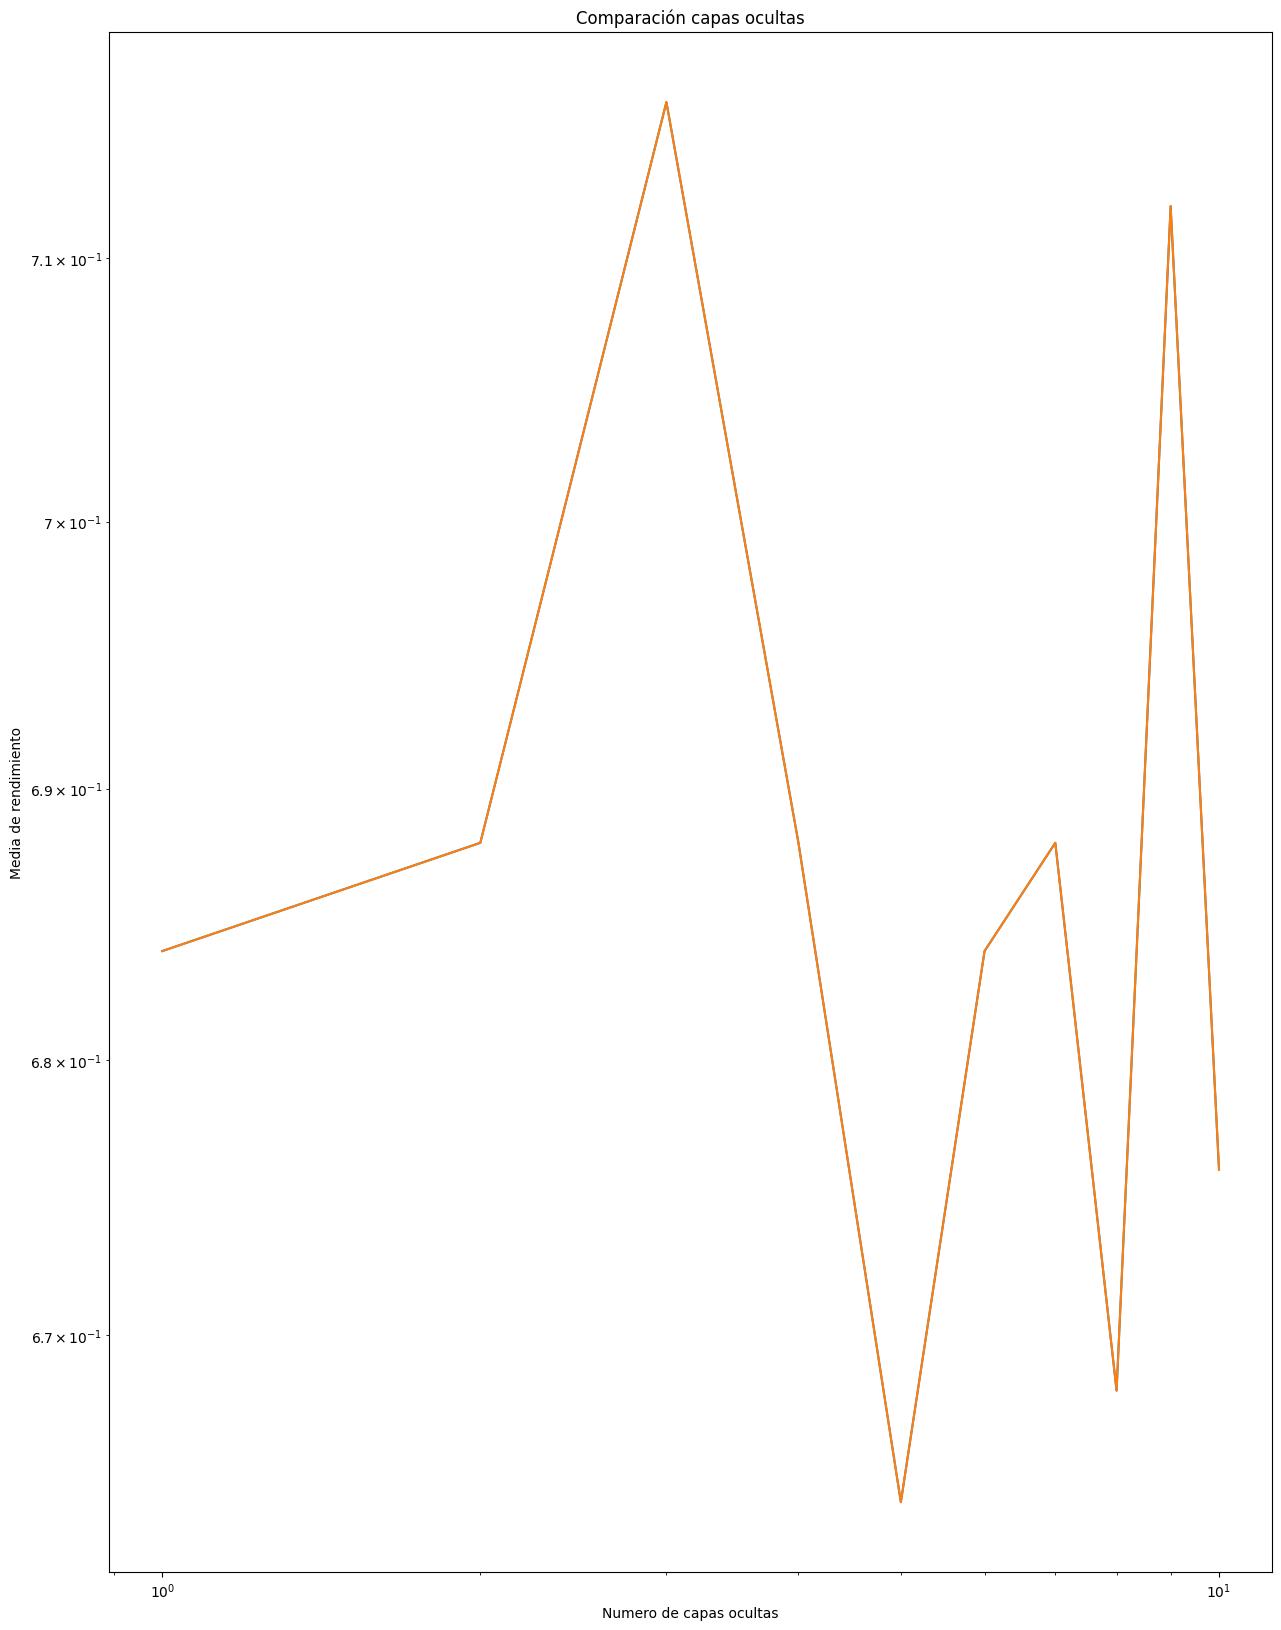


Con 3 capas, se tiene una puntuación de 0.716


In [25]:
number_layers = 10
neurons_layer = 30

x_val = [i for i in range(1, number_layers +1)]
layers = [(neurons_layer,)*i for i in range(1, number_layers +1)]
headers= ["Nº capas", "Puntuacion media"]

score_means = list()
data_table = list()

for i in layers:
    clf = MLPClassifier(hidden_layer_sizes=i, max_iter=3000,alpha=0.0) # 3000 iteraciones para evitar el ConvergenceWarning
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0) # division del entrenamiento
    clf.fit(X_train, y_train) # entrenamiento
    
    scores = cross_val_score(clf, X_test, y_test, cv=10) # 10-fold cross-validation
    m = scores.mean()
    score_means.append(m)
    data_table.append([len(i), m])


print(pd.DataFrame({headers[0]:x_val, headers[1]:score_means}).to_string(index=False))
print()  
plt.figure(figsize=(15, 20))

plt.plot(x_val, score_means)

plt.loglog(x_val, score_means)
plt.xlabel("Numero de capas ocultas")
plt.ylabel("Media de rendimiento")
plt.title("Comparación capas ocultas")
plt.show()


scores_cpy = score_means.copy()

scores_cpy.sort(reverse=True)

print()
print("Con", str(x_val[score_means.index(scores_cpy[0])]) + " capas, se tiene una puntuación de " + str(scores_cpy[0]))


Como parece reflejar la gráfica, para este conjunto de datos lo más óptimo serían 3 capas ocultas con 30 neuronas cada una (para este conjunto de datos en concreto).

## Procesamiento

En ocasiones, en lugar de utilizar modelos más complejos, es más útil invertir más tiempo en el procesamiento de los datos para conseguir mejores resultados.

En este apartado vas a investigar mecanismos para preparar los datos y obtener (en principio) mejores resultados: construcción y selección de atributos, preprocesamiento (detección de outliers, missing values, centrado y escalado).

Razona por qué decides probar o ignorar alguno de estos métodos, y cómo cambian los resultados al aplicarlos (puedes crear tantas celdas como consideres oportunas).
Usa tablas, gráficas y código, según sea necesario, para ilustrar tus observaciones.

In [2]:
df = pd.read_csv('./data/german_credit_data_numeric.csv', sep=';')
class_label = 'Class'
feature_names = list(df.columns)
feature_names.remove(class_label)
X = df[feature_names].values
y = df[class_label].values
# seleccion de atributos

# Se obtienen los distintos conjuntos de train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)


### Construcción y selección de atributos

### Preprocesamiento

#### Outlier detection

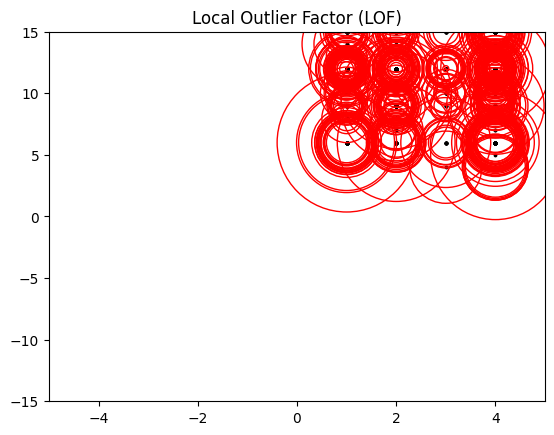

In [71]:
clf = LocalOutlierFactor(n_neighbors=20)
y_pred = clf.fit_predict(X)
X_scores = clf.negative_outlier_factor_

plt.scatter(X[:, 0], X[:, 1], color="k", s=3.0, label="Data points")
# radio del circulo
radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())
scatter = plt.scatter(
    X[:, 0],
    X[:, 1],
    s=10000* radius,
    edgecolors="r",
    facecolors="none",
    label="Outlier scores",
)
plt.axis("tight")
plt.xlim((-5, 5))
plt.ylim((-15, 15))

plt.title("Local Outlier Factor (LOF)")
plt.show()

A través de la función LocalOutlierFactor, se pueden obtener los Outliers scores, es decir la desviación de la densidad local. En el caso del dataset dado, como se puede apreciar hay muchos outliers.

#### Missing Values

In [92]:
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(X)


X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
X_train_vals, X_test_vals, y_train_vals, y_test_vals = train_test_split(imp.transform(X), y, random_state=0)


normal_scores= list()
no_missing_scores= list()

for i in range(10):
    
    clf = MLPClassifier(hidden_layer_sizes=(30,30,30,), max_iter=3000,alpha=0.0) # 3000 iteraciones para evitar el ConvergenceWarning
    clf.fit(X_train, y_train) # entrenamiento
        
    scores = cross_val_score(clf, X_test, y_test, cv=10) # 10-fold cross-validation
    
    normal_scores.append(mean(scores))
    
    clf2 = MLPClassifier(hidden_layer_sizes=(30,30,30,), max_iter=3000,alpha=0.0) # 3000 iteraciones para evitar el ConvergenceWarning
    clf2.fit(X_train_vals, y_train_vals) # entrenamiento
        
    scores = cross_val_score(clf, X_test_vals, y_test_vals, cv=10) # 10-fold cross-validation
    
    no_missing_scores.append(mean(scores))
    
print("Con los datos normales ", mean(normal_scores), "\nHabiendo sustituido los datos faltantes", mean(no_missing_scores))


Con los datos normales  0.7276 
Habiendo sustituido los datos faltantes 0.7363999999999999


Parece que no hay mucha mejoría, esto se puede deber a que o bien no faltan datos, o bien son muy pocos los faltantes.

#### Estandarización 

In [25]:
# preprocesamiento - estandarización
# se estandariza el data set
scaler = preprocessing.StandardScaler().fit(X_train)
X_scaled = scaler.transform(X_train)


scaler_scores= list()
no_scaler_scores= list()

for i in range(10):
    
    clf = MLPClassifier(hidden_layer_sizes=(30,30,30,), max_iter=3000,alpha=0.0) # 3000 iteraciones para evitar el ConvergenceWarning
    clf.fit(X_scaled, y_train) # entrenamiento
        
    scores = cross_val_score(clf, X_test, y_test, cv=10) # 10-fold cross-validation
    
    scaler_scores.append(mean(scores))
    
    clf2 = MLPClassifier(hidden_layer_sizes=(30,30,30,), max_iter=3000,alpha=0.0) # 3000 iteraciones para evitar el ConvergenceWarning
    clf2.fit(X_train, y_train) # entrenamiento
        
    scores = cross_val_score(clf, X_test, y_test, cv=10) # 10-fold cross-validation
    
    no_scaler_scores.append(mean(scores))
    
print("Con StandardScaler ", mean(scaler_scores), "\nSin StandardScaler", mean(no_scaler_scores))

Con StandardScaler  0.7232 
Sin StandardScaler 0.7244


In [28]:
# preprocesamiento - estandarización
# se estandariza el data set
scaler = preprocessing.MinMaxScaler().fit(X_train)
X_scaled = scaler.transform(X_train)


scaler_scores= list()

for i in range(10):
    
    clf = MLPClassifier(hidden_layer_sizes=(30,30,30,), max_iter=3000,alpha=0.0) # 3000 iteraciones para evitar el ConvergenceWarning
    clf.fit(X_scaled, y_train) # entrenamiento
        
    scores = cross_val_score(clf, X_test, y_test, cv=10) # 10-fold cross-validation
    
    scaler_scores.append(mean(scores))
    
print("Con MinMaxScaler ", mean(scaler_scores), "\nSin MinMaxScaler", mean(no_scaler_scores))

Con MinMaxScaler  0.7248 
Sin MinMaxScaler 0.7244


In [74]:
# preprocesamiento - estandarización
# se estandariza el data set
X_scale = preprocessing.scale(X_train)

scaler_scores= list()

for i in range(10):
    
    clf = MLPClassifier(hidden_layer_sizes=(30,30,30,), max_iter=3000,alpha=0.0) # 3000 iteraciones para evitar el ConvergenceWarning
    clf.fit(X_scale, y_train) # entrenamiento
        
    scores = cross_val_score(clf, X_test, y_test, cv=10) # 10-fold cross-validation
    
    scaler_scores.append(mean(scores))
    
print("Con scale ", mean(scaler_scores), "\nSin scale", mean(no_scaler_scores))

Con scale  0.7256 
Sin scale 0.7244


Parece que no hay mucha diferencia, lo cual significa o bien que el centrado y escalado no tiene mucho peso con respecto a la predicción de las redes neuronales, o bien que los datos de 'german_credit_data_numeric.csv' ya están estandarizados.

## Hiperparámetros


¿Cómo se determina el valor de los hiperparámetros?

Para determinar el valor de los hiperparámetros de un modelo realizaremos una búsqueda en una rejilla. De entre los valores considerados seleccionaremos los que maximicen la estimación por validación cruzada (K = 10) de la tasa de acierto.

Adapta el código que encontrarás en 
[https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html#sphx-glr-auto-examples-model-selection-plot-grid-search-digits-py](https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html#sphx-glr-auto-examples-model-selection-plot-grid-search-digits-py)
a este problema. 

En los tutoriales
[https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html](
    https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)
[https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)
hay información sobre cada uno de los hiper-parámetros. 
Puedes elegir el conjunto de hiperparametros en el que se realiza la optimización. 
Antes de elegir la rejilla de hiperparámetros, asegúrate de que entiendes su para asegurarte que tiene sentido la búsqueda.

In [9]:
def print_dataframe(filtered_cv_results):
    """Pretty print for filtered dataframe"""
    for mean_precision, std_precision, mean_recall, std_recall, params in zip(
        filtered_cv_results["mean_test_precision"],
        filtered_cv_results["std_test_precision"],
        filtered_cv_results["mean_test_recall"],
        filtered_cv_results["std_test_recall"],
        filtered_cv_results["params"],
    ):
        print(
            f"precision: {mean_precision:0.3f} (±{std_precision:0.03f}),"
            f" recall: {mean_recall:0.3f} (±{std_recall:0.03f}),"
            f" for {params}"
        )
    print()

def refit_strategy(cv_results):
    """Define the strategy to select the best estimator.

    The strategy defined here is to filter-out all results below a precision threshold
    of 0.98, rank the remaining by recall and keep all models with one standard
    deviation of the best by recall. Once these models are selected, we can select the
    fastest model to predict.

    Parameters
    ----------
    cv_results : dict of numpy (masked) ndarrays
        CV results as returned by the `GridSearchCV`.

    Returns
    -------
    best_index : int
        The index of the best estimator as it appears in `cv_results`.
    """
    # print the info about the grid-search for the different scores
    precision_threshold = 0.98

    cv_results_ = pd.DataFrame(cv_results)
    print("All grid-search results:")
    print_dataframe(cv_results_)

    # Filter-out all results below the threshold
    high_precision_cv_results = cv_results_[
        cv_results_["mean_test_precision"] > precision_threshold
    ]

    print(f"Models with a precision higher than {precision_threshold}:")
    print_dataframe(high_precision_cv_results)

    high_precision_cv_results = high_precision_cv_results[
        [
            "mean_score_time",
            "mean_test_recall",
            "std_test_recall",
            "mean_test_precision",
            "std_test_precision",
            "rank_test_recall",
            "rank_test_precision",
            "params",
        ]
    ]

    # Select the most performant models in terms of recall
    # (within 1 sigma from the best)
    best_recall_std = high_precision_cv_results["mean_test_recall"].std()
    best_recall = high_precision_cv_results["mean_test_recall"].max()
    best_recall_threshold = best_recall - best_recall_std

    high_recall_cv_results = high_precision_cv_results[
        high_precision_cv_results["mean_test_recall"] > best_recall_threshold
    ]
    print(
        "Out of the previously selected high precision models, we keep all the\n"
        "the models within one standard deviation of the highest recall model:"
    )
    print_dataframe(high_recall_cv_results)

    # From the best candidates, select the fastest model to predict
    fastest_top_recall_high_precision_index = high_recall_cv_results[
        "mean_score_time"
    ].idxmin()

    print(
        "\nThe selected final model is the fastest to predict out of the previously\n"
        "selected subset of best models based on precision and recall.\n"
        "Its scoring time is:\n\n"
        f"{high_recall_cv_results.loc[fastest_top_recall_high_precision_index]}"
    )

    return fastest_top_recall_high_precision_index


# ----------------------------------------------------------
digits = datasets.load_digits()
n_samples = len(digits.images)
X = digits.images.reshape((n_samples, -1))
y = digits.target == 8
print(
    f"The number of images is {X.shape[0]} and each image contains {X.shape[1]} pixels"
)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

tuned_parameters = [
    {"algorithm":["ball_tree", "kd_tree", "brute"],"n_neighbors":[2,4,5,8,10,15,20,25,35,45,60], "leaf_size":[10,20,30,40]},
]
scores = ["precision", "recall"]

grid_search = GridSearchCV(
    KNeighborsClassifier(), tuned_parameters, scoring=scores, refit=refit_strategy
)
grid_search.fit(X_train, y_train)

tuned_parameters = [
    {"criterion":["gini", "entropy", "log_loss"],"max_depth":[2,4,5,8,10,15,20,25,35,45,60]},
]

grid_search = GridSearchCV(
    DecisionTreeClassifier(), tuned_parameters, scoring=scores, refit=refit_strategy
)
grid_search.fit(X_train, y_train)


The number of images is 1797 and each image contains 64 pixels
All grid-search results:
precision: 0.972 (±0.035), recall: 0.900 (±0.129), for {'algorithm': 'ball_tree', 'leaf_size': 10, 'n_neighbors': 2}
precision: 0.961 (±0.049), recall: 0.876 (±0.088), for {'algorithm': 'ball_tree', 'leaf_size': 10, 'n_neighbors': 4}
precision: 0.962 (±0.049), recall: 0.914 (±0.063), for {'algorithm': 'ball_tree', 'leaf_size': 10, 'n_neighbors': 5}
precision: 0.988 (±0.025), recall: 0.865 (±0.027), for {'algorithm': 'ball_tree', 'leaf_size': 10, 'n_neighbors': 8}
precision: 0.988 (±0.025), recall: 0.841 (±0.050), for {'algorithm': 'ball_tree', 'leaf_size': 10, 'n_neighbors': 10}
precision: 0.936 (±0.055), recall: 0.817 (±0.055), for {'algorithm': 'ball_tree', 'leaf_size': 10, 'n_neighbors': 15}
precision: 0.946 (±0.048), recall: 0.793 (±0.059), for {'algorithm': 'ball_tree', 'leaf_size': 10, 'n_neighbors': 20}
precision: 0.970 (±0.036), recall: 0.781 (±0.048), for {'algorithm': 'ball_tree', 'leaf_si

/home/seregio/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/seregio/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/seregio/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/seregio/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: Undefi

All grid-search results:
precision: 0.000 (±0.000), recall: 0.000 (±0.000), for {'criterion': 'gini', 'max_depth': 2}
precision: 0.712 (±0.061), recall: 0.732 (±0.045), for {'criterion': 'gini', 'max_depth': 4}
precision: 0.779 (±0.054), recall: 0.719 (±0.032), for {'criterion': 'gini', 'max_depth': 5}
precision: 0.761 (±0.145), recall: 0.694 (±0.045), for {'criterion': 'gini', 'max_depth': 8}
precision: 0.735 (±0.054), recall: 0.707 (±0.050), for {'criterion': 'gini', 'max_depth': 10}
precision: 0.773 (±0.102), recall: 0.682 (±0.073), for {'criterion': 'gini', 'max_depth': 15}
precision: 0.761 (±0.075), recall: 0.718 (±0.055), for {'criterion': 'gini', 'max_depth': 20}
precision: 0.745 (±0.039), recall: 0.669 (±0.089), for {'criterion': 'gini', 'max_depth': 25}
precision: 0.772 (±0.074), recall: 0.707 (±0.030), for {'criterion': 'gini', 'max_depth': 35}
precision: 0.756 (±0.078), recall: 0.731 (±0.053), for {'criterion': 'gini', 'max_depth': 45}
precision: 0.789 (±0.115), recall: 0.67

ValueError: attempt to get argmin of an empty sequence

## ¿Cómo se estima el error de generalización?

Estimaremos el error de generalización de cada clasificador usando *Nested Cross Validation*. 


Adapta el código que encontrarás en https://scikit-learn.org/stable/auto_examples/model_selection/plot_nested_cross_validation_iris.html para resolver este problema con una red neuronal. 


In [ ]:

# Number of random trials
NUM_TRIALS = 1

# Load the dataset
iris = datasets.load_iris()
X_iris = iris.data
y_iris = iris.target

# Set up possible values of parameters to optimize over
p_grid = {"hidden_layer_sizes": [(100,),(30,30,30,), (15,30,20,), (15,20,30,), (30,20,15,), (100,30,)], 
          "learning_rate":["constant", "invscaling", "adaptive"]}

# We will use a Support Vector Classifier with "rbf" kernel
svm = MLPClassifier(max_iter=3000,alpha=0.0)

# Arrays to store scores
non_nested_scores = np.zeros(NUM_TRIALS)
nested_scores = np.zeros(NUM_TRIALS)

# Loop for each trial
for i in range(NUM_TRIALS):
    # Choose cross-validation techniques for the inner and outer loops,
    # independently of the dataset.
    # E.g "GroupKFold", "LeaveOneOut", "LeaveOneGroupOut", etc.
    inner_cv = KFold(n_splits=4, shuffle=True, random_state=i)
    outer_cv = KFold(n_splits=4, shuffle=True, random_state=i)

    # Non_nested parameter search and scoring
    clf = GridSearchCV(estimator=svm, param_grid=p_grid, cv=outer_cv)
    clf.fit(X_iris, y_iris)
    non_nested_scores[i] = clf.best_score_

    # Nested CV with parameter optimization
    clf = GridSearchCV(estimator=svm, param_grid=p_grid, cv=inner_cv)
    nested_score = cross_val_score(clf, X=X_iris, y=y_iris, cv=outer_cv)
    nested_scores[i] = nested_score.mean()

score_difference = non_nested_scores - nested_scores

print(
    "Average difference of {:6f} with std. dev. of {:6f}.".format(
        score_difference.mean(), score_difference.std()
    )
)

# Plot scores on each trial for nested and non-nested CV
plt.figure()
plt.subplot(211)
(non_nested_scores_line,) = plt.plot(non_nested_scores, color="r")
(nested_line,) = plt.plot(nested_scores, color="b")
plt.ylabel("score", fontsize="14")
plt.legend(
    [non_nested_scores_line, nested_line],
    ["Non-Nested CV", "Nested CV"],
    bbox_to_anchor=(0, 0.4, 0.5, 0),
)
plt.title(
    "Non-Nested and Nested Cross Validation on Iris Dataset",
    x=0.5,
    y=1.1,
    fontsize="15",
)

# Plot bar chart of the difference.
plt.subplot(212)
difference_plot = plt.bar(range(NUM_TRIALS), score_difference)
plt.xlabel("Individual Trial #")
plt.legend(
    [difference_plot],
    ["Non-Nested CV - Nested CV Score"],
    bbox_to_anchor=(0, 1, 0.8, 0),
)
plt.ylabel("score difference", fontsize="14")

plt.show()

## ¿Cuál es el mejor clasificador?

* De acuerdo con los resultados de los anteriores apartados, indica cuál es el mejor clasificador encontrado.
* ¿Cuáles son los valores de los hiperparámetros utilizados para configurar y entrenar tal  clasificador?
* ¿cuáles son los valores de los parámetros del clasificador entrenado?
* Proporciona una estimación del error de generalización por validación cruzada, así como de la incertidumbre de dicha estimación.


## Conclusiones.
Resume los resultados y conclusiones del estudio que has realizado.


[POR HACER]
